In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras import losses

2024-04-22 14:20:39.136745: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-22 14:20:39.141047: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-22 14:20:39.196710: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-22 14:20:39.907943: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
print(tf.__version__)

2.16.1


In [3]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84125825/84125825 ━━━━━━━━━━━━━━━━━━━━ 17s 0us/step


In [4]:
os.listdir(dataset_dir)

['test', 'train', 'README', 'imdb.vocab', 'imdbEr.txt']

In [5]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['pos',
 'urls_unsup.txt',
 'urls_pos.txt',
 'unsup',
 'urls_neg.txt',
 'labeledBow.feat',
 'neg',
 'unsupBow.feat']

In [6]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [7]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [8]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


2024-04-22 14:23:43.170479: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-22 14:23:43.171399: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [9]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

2024-04-22 14:23:49.770733: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [10]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [11]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [12]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


In [13]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [14]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [15]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

2024-04-22 14:25:20.990285: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [16]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [17]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br />T

In [18]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


In [19]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [21]:
embedding_dim = 16

In [22]:
model = tf.keras.Sequential([
  layers.Embedding(max_features, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1, activation='sigmoid')])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [23]:
model.compile(loss=losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])

In [24]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.5873 - loss: 0.6797 - val_binary_accuracy: 0.7428 - val_loss: 0.6075
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.7636 - loss: 0.5744 - val_binary_accuracy: 0.8098 - val_loss: 0.4969
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.8263 - loss: 0.4651 - val_binary_accuracy: 0.8334 - val_loss: 0.4262
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.8542 - loss: 0.3931 - val_binary_accuracy: 0.8406 - val_loss: 0.3868
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.8677 - loss: 0.3475 - val_binary_accuracy: 0.8482 - val_loss: 0.3609
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.8808 - loss: 0.3151 - val_binary_accuracy: 0.8538 - val_loss: 0.3434
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.8920 - loss: 0.2889 - val_binary_accuracy: 0.8564 - val_loss: 0.3320
Epoch 

In [25]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - binary_accuracy: 0.8503 - loss: 0.3370
Loss:  0.3337651491165161
Accuracy:  0.8543999791145325


In [26]:
history_dict = history.history
history_dict.keys()

dict_keys(['binary_accuracy', 'loss', 'val_binary_accuracy', 'val_loss'])

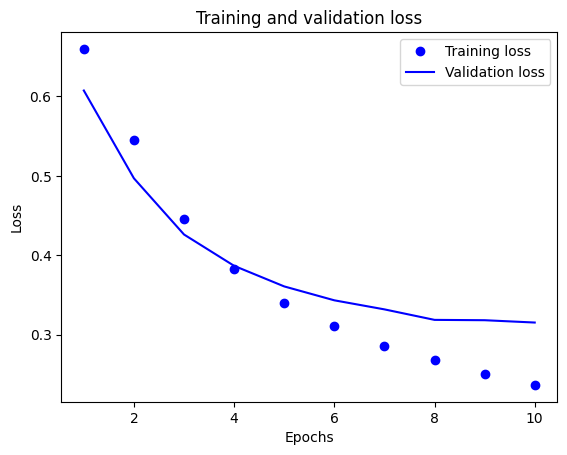

In [27]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

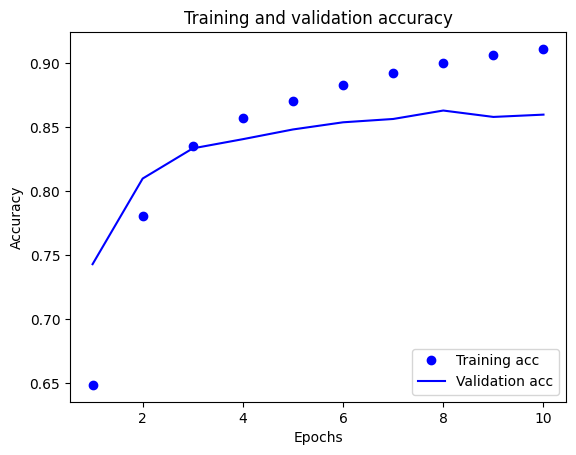

In [28]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [29]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5035 - loss: 0.5879
0.5


In [30]:
examples = tf.constant([
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
])

export_model.predict(examples)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


array([[0.5767074 ],
       [0.54388607],
       [0.5316382 ]], dtype=float32)